# Learning the ceritificate and partitioning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F 
import torch.optim as optim 

from envs import Spiral
from learner import ReachNN

## Certificate

In [10]:
env = Spiral(alpha=0.5, beta=0.5)
net = ReachNN()

def loss_fn(net, x_tgt, x_dec):
    return 1*loss_tgt(net, x_tgt) + 32*loss_dec(net, x_dec)

def loss_tgt(net, x_tgt):
    N = len(x_tgt)
    return 1/N * torch.sum(
        torch.relu(net(x_tgt) - 0.3)
    )

# Tunable hyperparameters for learning: eps, lr

def loss_dec(net, x_dec, eps=1e-2):
    f = torch.vmap(env.f)
    x_nxt = f(x_dec)
    
    zero = torch.zeros(x_dec.shape)
    N = len(x_dec)
    return 1/N * torch.sum(
        torch.maximum(net(x_nxt) - net(x_dec) + eps, zero)
    )

optimizer = optim.SGD(
    net.parameters(),
    lr=1e-3, 
    weight_decay=1e-4
)

N_EPOCH, N_BATCH = 512, 40

x = torch.rand(16000, 2)*2 - 1
tgt_mask = torch.logical_and(
    torch.abs(x[:,0]) <= 0.05,
    torch.abs(x[:,1]) <= 0.05,
)
x_dec = x[~tgt_mask]
x_tgt = torch.rand(4000, 2)*0.1 - 0.05

print(f'|x_tgt|={len(x_tgt)}, |x_dec|={len(x_dec)}')

tgt_ld = D.DataLoader(x_tgt, batch_size= 50, shuffle=True)
dec_ld = D.DataLoader(x_dec, batch_size=200, shuffle=True)

for e in range(N_EPOCH+1):
    epoch_loss = 0
    n_batch = 0
    tgt_it, dec_it = iter(tgt_ld), iter(dec_ld)
    for b in range(N_BATCH):
        x_t, x_d = next(tgt_it), next(dec_it)
        optimizer.zero_grad()
        loss = loss_fn(net, x_t, x_d)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        n_batch += 1
    if e % 64 == 0:
        print(f'{e:>3}. Loss={epoch_loss:8.6f}, n_batch={n_batch}')

|x_tgt|=4000, |x_dec|=15957
  0. Loss=26.074177, n_batch=40
 64. Loss=21.375464, n_batch=40
128. Loss=17.976819, n_batch=40
192. Loss=11.751372, n_batch=40
256. Loss=0.299131, n_batch=40
320. Loss=0.167620, n_batch=40
384. Loss=0.114154, n_batch=40
448. Loss=0.096943, n_batch=40
512. Loss=0.081695, n_batch=40


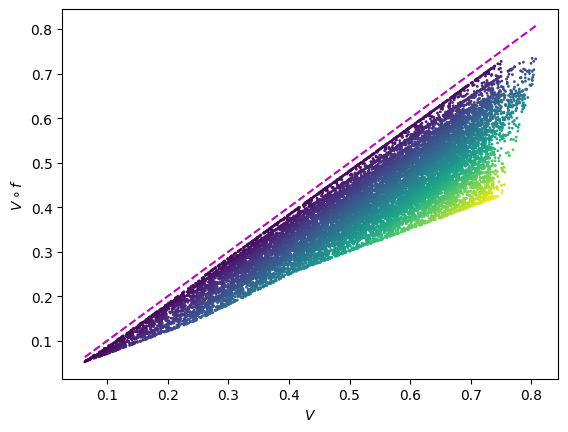

In [54]:
tgt_mask = torch.logical_and(
    torch.abs(x[:,0]) <= 0.05,
    torch.abs(x[:,1]) <= 0.05,
)
x = x[~tgt_mask]

v = net(x)
vf = net(torch.vmap(env.f)(x))
v, vf = v.detach(), vf.detach()
plt.plot(
    [torch.min(v), torch.max(v)], [torch.min(v), torch.max(v)], 'm--')
plt.scatter(v, vf, c=torch.relu(v-vf), s=1)
plt.xlabel(r'$V$')
plt.ylabel(r'$V \circ f$')
plt.show()

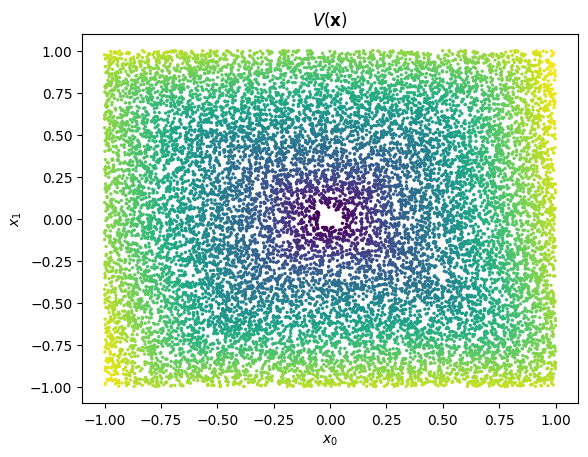

In [55]:
plt.scatter(x[:,0], x[:,1],c=v, s=2)
plt.title(r'$V(\mathbf{x})$')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.show()

## Partitioning

In [56]:
def binary_search(a, n, f):
    """Binary search with a given condition f.
    
    Returns: 
      l: highest value for i where f[i] holds.
      r: lowest  value for i where f[i] does not hold.
    """
    l, r = -1, n
    while r-l > 1:
        m = (l+r) >> 1
        if f(a[m]):
            l = m
        else:
            r = m
    return l, r

def partition(x: torch.Tensor, v, f):
    # Assumption. The learned certificate does not violate the 
    # decrease condition on any of the states given in x.
    f_vmap = torch.vmap(f)
    assert torch.all(v(x) > v(f_vmap(x)))
    
    _, sort_idx = torch.sort(v(x), dim=0)
    # Sort x such that (i < j) <=> v(x[i]) < v(x[j])
    x = x[sort_idx]
    # Remove extra dimensions of size 1 that come from 
    # picking certain indices of x.
    # After this step, x should be a Nx2 matrix.
    x = torch.squeeze(x)
    
    # A list of all partitions.
    # For each partition p, p[0] is the _representative_ of p.
    # This property of the partitions enables us to use binary 
    # search when choosing an existing partition for a new point.
    P = []
    for i in range(len(x)):
        # idx is the first existing partition to which we can 
        # add x[i].
        _, idx = binary_search(
            P, len(P), lambda p: v(f(x[i])) >= v(p[0]))
        if idx == len(P): 
            # x[i] cannot be added to any of the existing partitions,
            # so we need to create its own partition.
            P.append( [x[i]] )
        else:
            P[idx].append(x[i])
    return x, P

x, P = partition(x, net, env.f)
print(f'|P|={len(P)}')

|P|=37


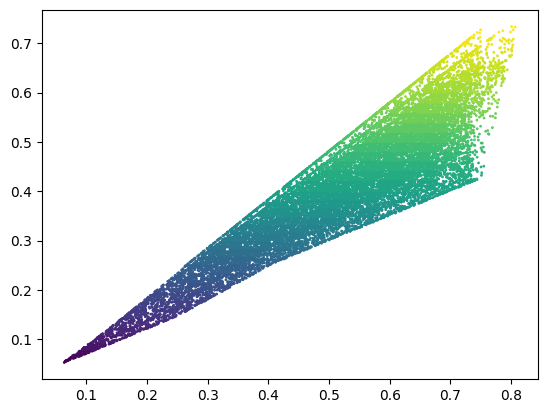

In [58]:
f_vec = torch.vmap(env.f)

x, v, vf, c = [], [], [], []
for i, p in enumerate(P):
    x_p = torch.vstack(p)
    x.append(x_p)
    v.append(net(x_p).detach())
    vf.append(net(f_vec(x_p)).detach())
    c.append(torch.ones(len(x_p))*i)

x = torch.vstack(x)
v = torch.vstack(v)
vf = torch.vstack(vf)
c = torch.cat(c)

plt.scatter(v, vf, c=c, s=1)

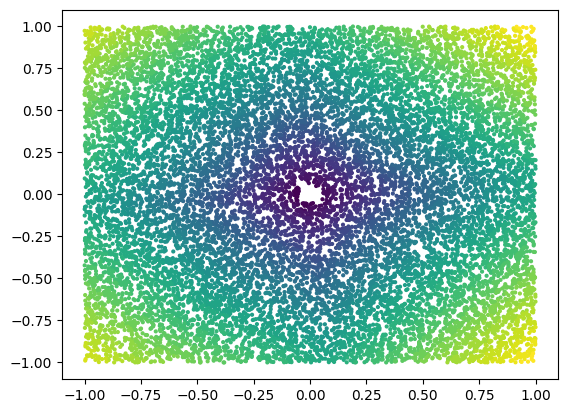

In [59]:
plt.scatter(x[:,0], x[:,1],c=c, s=4)

In [60]:
def partition(x, y):
    N = len(x)
    P = []
    
    for i in range(N):
        print(f'i={i}. P={P}')
        # idx is the lowest value where v(f(x[i])) < v[x[idx]]
        _, idx = binary_search(
            P, len(P), lambda p: y[i] >= p[0][0])
        print(f'  idx={idx}')
        if idx == len(P):
            P.append( [(x[i], y[i])] )
        else:
            P[idx].append( (x[i], y[i]) )
    return x, P

x = [2,   3, 4,   5,    6, 7]
y = [1, 1.5, 3, 1.75, 3.5, 5]

x, P = partition(x, y)
print(f'P={P}')

i=0. P=[]
  idx=0
i=1. P=[[(2, 1)]]
  idx=0
i=2. P=[[(2, 1), (3, 1.5)]]
  idx=1
i=3. P=[[(2, 1), (3, 1.5)], [(4, 3)]]
  idx=0
i=4. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3)]]
  idx=1
i=5. P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)]]
  idx=2
P=[[(2, 1), (3, 1.5), (5, 1.75)], [(4, 3), (6, 3.5)], [(7, 5)]]
